In [1]:
import pylcp
import numpy as np
from scipy import constants as const
from sympy.physics.wigner import wigner_3j, wigner_6j, wigner_9j
import time
import pathos
import multiprocessing as mp
import dill
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmcrameri.cm as scicmap
import tqdm

gamma = 2*np.pi*2.79e6 # Hz
k = 2*np.pi/860e-9 # m^-1

t_unit = 1/gamma
#t_unit = 1e-10

m_unit = 1/k
#m_unit = 1e-9

velocity_unit = m_unit/t_unit
accel_unit = m_unit/t_unit**2
Hz_unit = 1/t_unit
lin_Hz_unit = 1/t_unit/2/np.pi
Js_unit = const.hbar # kg m^2/s
mass_unit = Js_unit*t_unit/m_unit**2
HzperT_unit = const.value("Bohr magneton")/(Js_unit)
T_unit = Hz_unit/HzperT_unit
amu_unit = mass_unit/1.66e-27
cm_unit = m_unit/1e-2
F_unit = mass_unit*m_unit/t_unit**2
I_sat = (np.pi*const.h*const.c*gamma)/(3*227.5e-9**3) # W/m^2

ksim=k*m_unit
gammasim=gamma/Hz_unit

c_cmpers = const.c*100

# global_det = 0.5*12*gammasim

H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
    N=1, I=1/2, B=0, gamma=2.69905e-3*c_cmpers/lin_Hz_unit, 
    b=(2.19651e-3-0.243647e-3/3)*c_cmpers/lin_Hz_unit, c=0.243647e-3*c_cmpers/lin_Hz_unit, CI=0/lin_Hz_unit, q0=0, q2=0,
    gS=-2.0023193043622, gI=0.,
    muB=1, return_basis=True
    )
E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    J=1/2, I=1/2, P=+1, a=0.8856e-3*c_cmpers/lin_Hz_unit, glprime=0,
    muB=1, return_basis=True
    )
E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, I=1/2, S=1/2, UX=U_X
    )

energies = np.unique(H0_X.diagonal())

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq, k=ksim, gamma=gammasim,mass=157/amu_unit)

# mag_field = pylcp.fields.quadrupoleMagneticField(1000*1e-4*cm_unit*HzperT_unit/Hz_unit)
mag_field = pylcp.fields.quadrupoleMagneticField(40*1e-4*cm_unit*HzperT_unit/Hz_unit)
no_mag_field = pylcp.fields.quadrupoleMagneticField(0*1e-4*cm_unit*HzperT_unit/Hz_unit)
static_field= lambda B : pylcp.fields.magField(B*1e-4*HzperT_unit/Hz_unit)

In [2]:
Bs = np.linspace(0,100,100)
EsX = np.array([np.linalg.eigh(const.physical_constants['Bohr magneton in Hz/T'][0]*Bq_X[1]*B*1e-6*1e-4 + H0_X)[0]*Hz_unit/2/np.pi/1e6 for B in Bs])
EsA = np.array([np.linalg.eigh(const.physical_constants['Bohr magneton in Hz/T'][0]*Bq_A[1]*B*1e-6*1e-4 + H0_A)[0]*Hz_unit/2/np.pi/1e6 for B in Bs])

In [3]:
EsX[0]

array([-94.82502624, -94.82502624, -94.82502624, -66.88783951,
        22.65982018,  22.65982018,  22.65982018,  56.67669154,
        56.67669154,  56.67669154,  56.67669154,  56.67669154])

Text(0, 0.5, '$\\Delta$E [MHz]')

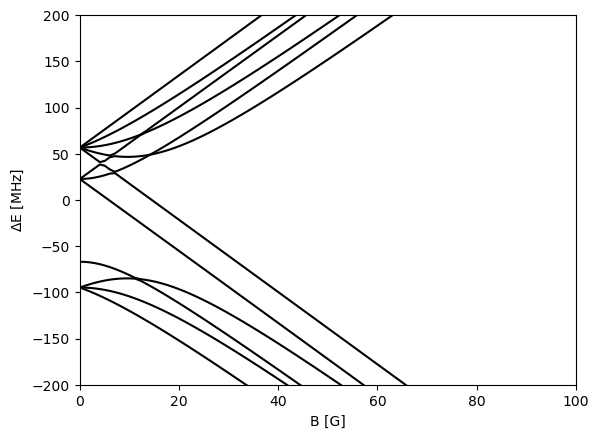

In [4]:
[plt.plot(Bs, EsX[:,i],'k') for i in range(EsX.shape[1])];
plt.ylim(-200,200)
plt.xlim(0,100)
plt.xlabel("B [G]")
plt.ylabel("$\\Delta$E [MHz]")

Text(0, 0.5, '$\\Delta$E [MHz]')

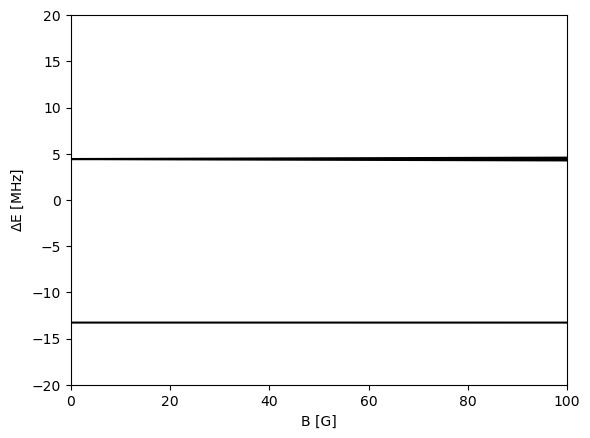

In [5]:
[plt.plot(Bs, EsA[:,i],'k') for i in range(EsA.shape[1])];
plt.ylim(-20,20)
plt.xlim(0,100)
plt.xlabel("B [G]")
plt.ylabel("$\\Delta$E [MHz]")

In [6]:
(E_A[0]-E_A[-1])*Hz_unit/2/np.pi/1e6

-17.699746720319997

In [7]:
sideband_0 = np.min(E_A) - np.max(E_X)

In [8]:
np.sort([(Ea - Ex - sideband_0)*Hz_unit/2/np.pi/1e6 for Ea in E_A for Ex in E_X])

array([  0.        ,  17.69974672,  34.01687137,  51.71661809,
       123.56453106, 141.26427778, 151.50171779, 169.20146451])

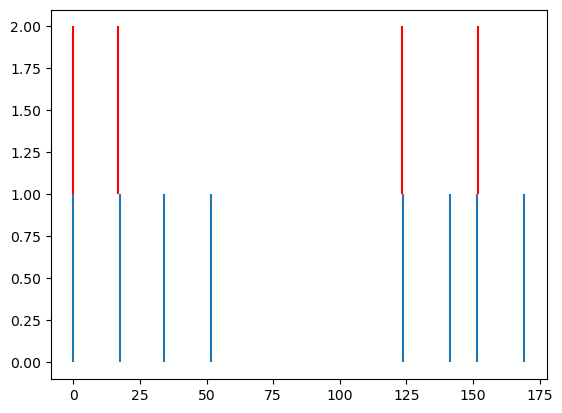

In [9]:
plt.vlines([(Ea - Ex - sideband_0)*Hz_unit/2/np.pi/1e6 for Ea in E_A for Ex in E_X],0,1)
plt.vlines([0,16.8,123.4,151.7],1,2,colors='r')

In [10]:
sideband_0*Hz_unit/2/np.pi/1e6

-69.95150158314343

In [17]:
s = 1
lasers = {
    'g->e' : pylcp.laserBeams([
        # {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 0, 1]), 'pol_coord':'cartesian', 'delta':-0/lin_Hz_unit, 's':0}#,?
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 1, 1])/np.sqrt(2), 'pol_coord':'cartesian', 'delta':sideband_0 + 0/lin_Hz_unit, 's':2*s},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 1, 1])/np.sqrt(2), 'pol_coord':'cartesian', 'delta':sideband_0 + 17.7/lin_Hz_unit, 's':s},
        # {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 1, 1])/np.sqrt(2), 'pol_coord':'cartesian', 'delta':-sideband_0 + 16.8/lin_Hz_unit, 's':s},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 1, 1])/np.sqrt(2), 'pol_coord':'cartesian', 'delta':sideband_0 + 123.564/lin_Hz_unit, 's':s},
        # {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 1, 1])/np.sqrt(2), 'pol_coord':'cartesian', 'delta':-sideband_0 + 123.4/lin_Hz_unit, 's':s},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 1, 1])/np.sqrt(2), 'pol_coord':'cartesian', 'delta':sideband_0 + 151.5017/lin_Hz_unit, 's':2*s},
        # {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 1, 1])/np.sqrt(2), 'pol_coord':'cartesian', 'delta':-sideband_0 + 151.7/lin_Hz_unit, 's':2*s},
        # {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 1, 0]), 'pol_coord':'cartesian', 'delta':-2.5e9/lin_Hz_unit, 's':1},
        # {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 1, 0]), 'pol_coord':'cartesian', 'delta':17e9/lin_Hz_unit, 's':1}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

In [18]:
mcwf = pylcp.MCWF(lasers,static_field(np.array([0,0.,2])),hamiltonian, include_mag_forces=True)

In [19]:
Nrun = 1
rtime = 0.25e-3

runs = []

# mcwf.set_initial_psi_equally()
mcwf.set_initial_psi(np.concatenate([[0]*12,[1/4]*4]))
mcwf.set_initial_position_and_velocity(np.array([0,0,0]), np.array([120/velocity_unit,0,0]))
for _ in tqdm.tqdm(range(Nrun)):
    runs.append(mcwf.evolve_motion([0,rtime/t_unit],
                t_eval=np.linspace(0,rtime/t_unit,1000000),
                progress_bar=True,freeze_axis=np.array([False,True,True]),max_step = 100e-5/t_unit,
                save_decay=True,
                rtol=1e-2, atol=np.concatenate(([1e-5]*16,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-1/cm_unit,1e-1/cm_unit,1e-1/cm_unit])),method="RK23"))

  0%|          | 0/1 [00:00<?, ?it/s]

Completed in 4:01.                                                   


100%|██████████| 1/1 [04:03<00:00, 243.78s/it]


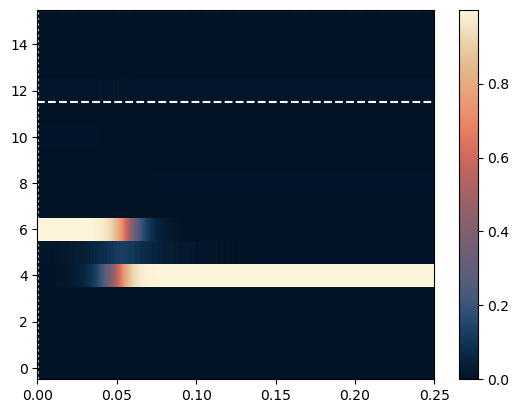

In [20]:
ev_times = [ev[-1]*t_unit*1e3 for ev in runs[0].decay_events]
c = plt.pcolormesh(*np.meshgrid(runs[0].t[:]*t_unit*1e3,list(range(runs[0].Psi.shape[0]))),np.abs(runs[0].Psi[:,:]),cmap=scicmap.lipari)
# plt.imshow(np.abs(runs[0].Psi[:,:]),aspect=2e4,cmap=scicmap.lipari)
xlim = plt.xlim()
ylim = plt.ylim()
plt.colorbar()
plt.hlines([11.5,15.5],*xlim,colors=["w","w"],linestyles=["dashed","dashed"])
plt.vlines(ev_times,*ylim, colors='w', linestyles='dotted',alpha=0.5)

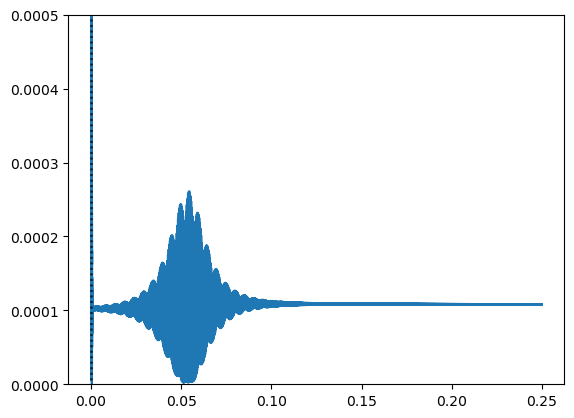

In [21]:
plt.plot(runs[0].t[:]*t_unit*1e3,np.sum(np.abs(runs[0].Psi[-4:])**2,axis=0))
plt.ylim(0,0.0005)
plt.vlines(ev_times,*ylim, colors='k', linestyles='dotted',alpha=0.5)